In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
# 1. 读取CSV文件
df = pd.read_csv(r"D:\分类数据\催化亚型活性内部训练集.csv",encoding = 'gbk')

# 2. 将pIC50列转化为标签（大于等于7为1，小于7为0）
df['label'] = np.where(df['pIC50'] >= 7, 1, 0)

In [3]:

# 3. SMILES转化为分子指纹（特征）
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)  # 生成Morgan指纹
    else:
        return np.zeros(1024)  # 如果SMILES无效，返回全零向量

# 将SMILES转化为特征矩阵
X = np.array([smiles_to_fingerprint(smiles) for smiles in df['smiles']])

# 4. 标签列
y = df['label']

[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerator
[15:54:16] DEPRECATION WARNING: please use MorganGenerat

In [4]:
# 5. 数据集划分为训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 6. 创建随机森林分类器
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [5]:
# 7. 模型训练
rf_model.fit(X_train, y_train)

# 8. 在训练集、验证集和测试集上评估模型
train_preds = rf_model.predict(X_train)
val_preds = rf_model.predict(X_val)
test_preds = rf_model.predict(X_test)

print("训练集分类报告：")
print(classification_report(y_train, train_preds))

print("验证集分类报告：")
print(classification_report(y_val, val_preds))

print("测试集分类报告：")
print(classification_report(y_test, test_preds))

训练集分类报告：
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4200
           1       0.99      1.00      0.99      4320

    accuracy                           0.99      8520
   macro avg       0.99      0.99      0.99      8520
weighted avg       0.99      0.99      0.99      8520

验证集分类报告：
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       548
           1       0.86      0.87      0.87       517

    accuracy                           0.87      1065
   macro avg       0.87      0.87      0.87      1065
weighted avg       0.87      0.87      0.87      1065

测试集分类报告：
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       505
           1       0.84      0.86      0.85       561

    accuracy                           0.84      1066
   macro avg       0.84      0.84      0.84      1066
weighted avg       0.84      0.84      0.84    

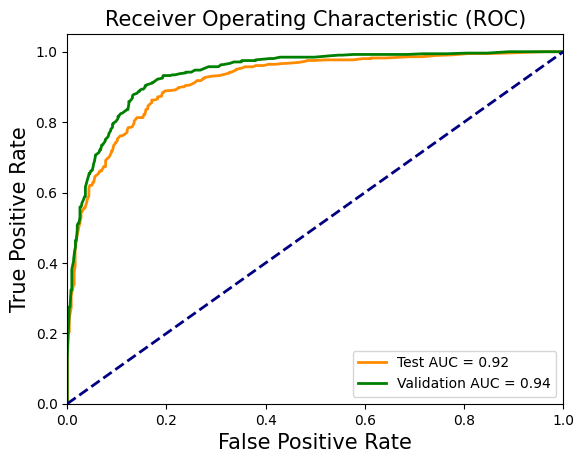

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 计算测试集的 ROC 曲线和 AUC
fpr_test, tpr_test, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# 计算验证集的 ROC 曲线和 AUC
fpr_val, tpr_val, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

# 保存 ROC 曲线数据
np.savez('roc_curve_data.npz', fpr_test=fpr_test, tpr_test=tpr_test, 
         roc_auc_test=roc_auc_test, fpr_val=fpr_val, tpr_val=tpr_val, 
         roc_auc_val=roc_auc_val)

# 绘制 ROC 曲线图
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test AUC = %0.2f' % roc_auc_test)
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation AUC = %0.2f' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)  # 标题字号加大
plt.legend(loc='lower right')

# 保存高清图，dpi=300
plt.savefig('roc_curve_hd1.png', dpi=500)
plt.show()


In [14]:
# 保存AUC曲线数据为CSV文件
auc_data_test = pd.DataFrame({'False Positive Rate': fpr_test, 'True Positive Rate': tpr_test})
auc_data_test['AUC'] = roc_auc_test
auc_data_test.to_csv(r"D:\图数据\二分类7内部测试集_AUC曲线数据.csv", index=False)

auc_data_val = pd.DataFrame({'False Positive Rate': fpr_val, 'True Positive Rate': tpr_val})
auc_data_val['AUC'] = roc_auc_val
auc_data_val.to_csv(r"D:\图数据\二分类7内部验证集_AUC曲线数据.csv", index=False)

In [ ]:
# 保存AUC曲线数据为CSV文件
auc_data = pd.DataFrame({'False Positive Rate': external_fpr, 'True Positive Rate': external_tpr})
auc_data['AUC'] = external_roc_auc
auc_data.to_csv(r"D:\图数据\二分类7外部验证集_AUC曲线数据.csv", index=False)

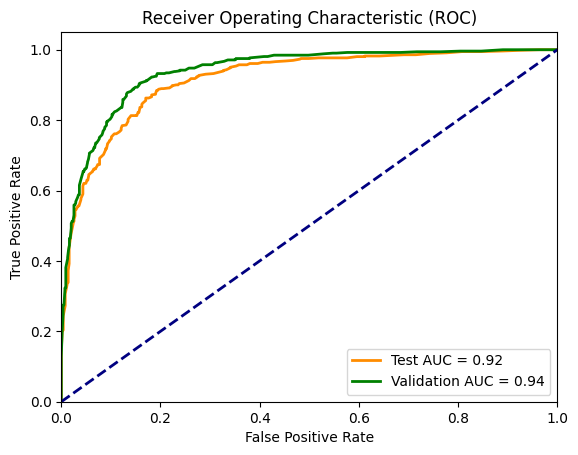

In [6]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # 9. 输出测试集的AUC曲线
# fpr_test, tpr_test, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
# roc_auc_test = auc(fpr_test, tpr_test)

# # 输出验证集的AUC曲线
# fpr_val, tpr_val, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:, 1])
# roc_auc_val = auc(fpr_val, tpr_val)

# # 绘制 ROC 曲线图
# plt.figure()
# plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test AUC = %0.2f' % roc_auc_test)
# plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation AUC = %0.2f' % roc_auc_val)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc='lower right')
# plt.savefig('roc_curve.png')
# plt.show()


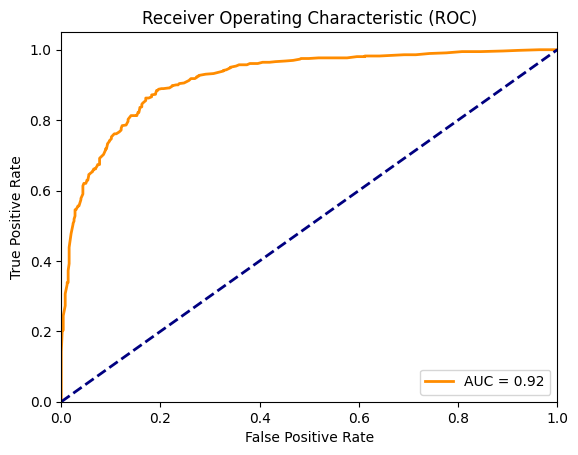

In [7]:
# 9. 输出测试集的AUC曲线
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

In [11]:
# 10. 保存训练好的模型
joblib.dump(rf_model, 'random_forest_model_7.pkl')

# 11. 加载模型并对外部数据集进行预测
loaded_model = joblib.load('random_forest_model_7.pkl')

[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerator
[16:05:22] DEPRECATION WARNING: please use MorganGenerat

外部数据集分类报告：
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       771
           1       0.71      0.47      0.56       313

    accuracy                           0.79      1084
   macro avg       0.76      0.70      0.71      1084
weighted avg       0.78      0.79      0.78      1084



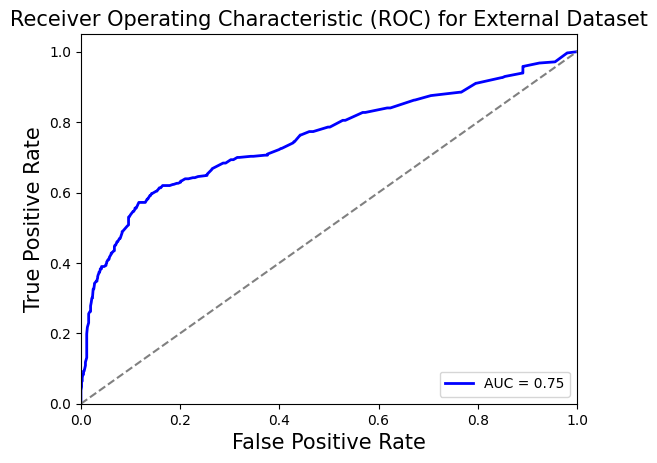

外部数据集预测结果已保存到 '催化亚型活性外部验证集的阈值为7活性分类结果.csv'
外部AUC曲线数据已保存到 'external_roc_curve_data.npz'
外部AUC高清图已保存到 'external_roc_curve_hd.png'


In [12]:
# 1. 加载外部数据集
external_df = pd.read_csv(r"D:\分类数据\催化亚型活性外部验证集.csv", encoding='gbk')

# 2. 将pIC50列转化为标签（大于等于7为1，小于7为0）
external_df['label'] = np.where(external_df['pIC50'] >= 7, 1, 0)

# 3. 将外部数据集的SMILES转化为分子指纹
external_X = np.array([smiles_to_fingerprint(smiles) for smiles in external_df['smiles']])

# 4. 标签列
external_y = external_df['label']

# 5. 对外部数据集进行预测
external_preds = loaded_model.predict(external_X)
external_proba = loaded_model.predict_proba(external_X)[:, 1]

# 6. 输出外部数据集的分类报告
print("外部数据集分类报告：")
print(classification_report(external_y, external_preds))

# 7. 绘制外部数据集的AUC曲线
external_fpr, external_tpr, _ = roc_curve(external_y, external_proba)
external_roc_auc = auc(external_fpr, external_tpr)

# 保存ROC曲线数据
np.savez('external_roc_curve_data.csv', fpr=external_fpr, tpr=external_tpr, auc=external_roc_auc)

plt.figure()
plt.plot(external_fpr, external_tpr, color='blue', lw=2, label='AUC = %0.2f' % external_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) for External Dataset', fontsize=15)  # 标题字号加大
plt.legend(loc='lower right')

# 保存高清图，dpi=300
plt.savefig(r"D:\分类数据\external_roc_curve_hd.png", dpi=1000)
plt.show()

# 8. 保存外部数据集预测结果
external_df['predicted_label'] = external_preds
external_df['predicted_proba'] = external_proba
external_df.to_csv(r"D:\分类数据\催化亚型活性外部验证集的阈值为7活性分类结果.csv", index=False)

print("外部数据集预测结果已保存到 '催化亚型活性外部验证集的阈值为7活性分类结果.csv'")
print("外部AUC曲线数据已保存到 'external_roc_curve_data.npz'")
print("外部AUC高清图已保存到 'external_roc_curve_hd.png'")


In [13]:
# 保存AUC曲线数据为CSV文件
auc_data = pd.DataFrame({'False Positive Rate': external_fpr, 'True Positive Rate': external_tpr})
auc_data['AUC'] = external_roc_auc
auc_data.to_csv(r"D:\图数据\二分类7外部验证集_AUC曲线数据.csv", index=False)

[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerator
[17:12:15] DEPRECATION WARNING: please use MorganGenerat

外部数据集分类报告：
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       771
           1       0.71      0.47      0.56       313

    accuracy                           0.79      1084
   macro avg       0.76      0.70      0.71      1084
weighted avg       0.78      0.79      0.78      1084



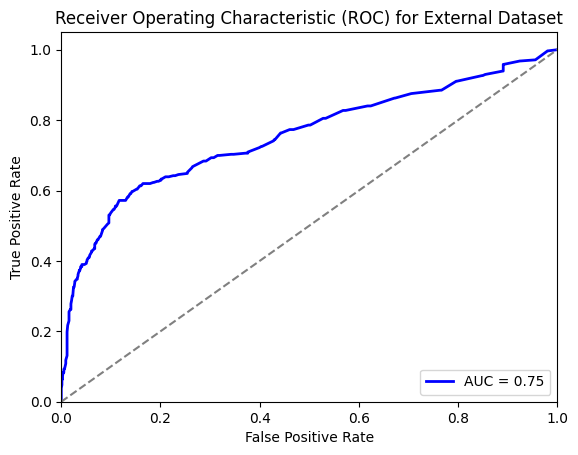

外部数据集预测结果已保存到 'external_predictions.csv'


In [8]:
# 1. 加载外部数据集
external_df = pd.read_csv(r"D:\分类数据\催化亚型活性外部验证集.csv", encoding='gbk')

# 2. 将pIC50列转化为标签（大于等于7为1，小于7为0）
external_df['label'] = np.where(external_df['pIC50'] >= 7, 1, 0)

# 3. 将外部数据集的SMILES转化为分子指纹
external_X = np.array([smiles_to_fingerprint(smiles) for smiles in external_df['smiles']])

# 4. 标签列
external_y = external_df['label']

# 5. 对外部数据集进行预测
external_preds = loaded_model.predict(external_X)
external_proba = loaded_model.predict_proba(external_X)[:, 1]

# 6. 输出外部数据集的分类报告
print("外部数据集分类报告：")
print(classification_report(external_y, external_preds))

# 7. 绘制外部数据集的AUC曲线
external_fpr, external_tpr, _ = roc_curve(external_y, external_proba)
external_roc_auc = auc(external_fpr, external_tpr)

plt.figure()
plt.plot(external_fpr, external_tpr, color='blue', lw=2, label='AUC = %0.2f' % external_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for External Dataset')
plt.legend(loc='lower right')
plt.savefig('external_roc_curve.png')
plt.show()

# 8. 保存外部数据集预测结果
external_df['predicted_label'] = external_preds
external_df['predicted_proba'] = external_proba
external_df.to_csv(r"D:\分类数据\催化亚型活性外部验证集的阈值为7活性分类结果.csv", index=False)

print("外部数据集预测结果已保存到 'external_predictions.csv'")


In [1]:
import pandas as pd


def calculate_tpr_fpr(labels, predicted_label):
    TP, FP, TN, FN = 0, 0, 0, 0
    for true_label, pred_label in zip(labels, predicted_label):
        if true_label == 1 and pred_label == 1:
            TP += 1
        elif true_label == 0 and pred_label == 1:
            FP += 1
        elif true_label == 0 and pred_label == 0:
            TN += 1
        elif true_label == 1 and pred_label == 0:
            FN += 1
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    return tpr, fpr


# 读取CSV文件
file_path = 'D:\分类数据\催化亚型活性外部验证集的阈值为7活性分类结果.csv'  # 请根据实际路径修改
data = pd.read_csv(file_path)
labels = data['label'].tolist()
predicted_label = data['predicted_label'].tolist()

tpr, fpr = calculate_tpr_fpr(labels, predicted_label)
print("TPR:", tpr)
print("FPR:", fpr)

TPR: 0.4696485623003195
FPR: 0.07911802853437094


In [13]:
# # 10. 保存训练好的模型
# joblib.dump(rf_model, 'random_forest_model_7.pkl')

# 11. 加载模型并对外部数据集进行预测
loaded_model = joblib.load('random_forest_model_7.pkl')

# 假设外部数据集为external_data.csv
external_df = pd.read_csv(r"D:\天然产物数据库\天然产物3-去空smiles.csv",encoding = 'gbk')

# 对外部数据集的SMILES列进行预测
external_X = np.array([smiles_to_fingerprint(smiles) for smiles in external_df['smiles']])

# 对外部数据集进行预测
external_preds = loaded_model.predict(external_X)

# 保存预测结果到文件
external_df['predicted_label'] = external_preds
external_df.to_csv(r"D:\天然产物数据库\天然产物3-去空smiles（阈值为7）.csv", index=False)

print("外部数据预测结果已保存到predicted_external_data.csv")

[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerator
[20:12:09] DEPRECATION WARNING: please use MorganGenerat

外部数据预测结果已保存到predicted_external_data.csv
